In [1]:
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
import coffea.hist as hist
import numpy as np
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore', category=RuntimeWarning)

/opt/conda/lib/python3.8/site-packages/coffea/util.py:154: FutureWarning: In coffea version v0.8.0 (target date: 31 Dec 2022), this will be an error.
(Set coffea.deprecations_as_errors = True to get a stack trace now.)
ImportError: coffea.hist is deprecated
  warnings.warn(message, FutureWarning)


In [2]:
def plothist(x, y, p):

    def gauss_function(x, a, mean, sigma):
        return a*np.exp(-(x - mean)**2/(2 * sigma**2))

    fig, ax = plt.subplots(figsize=(7,7),)

    ax.plot(x, gauss_function(x, *p))
    ax.plot(x, y, 'ok')

from scipy.optimize import curve_fit

def gaussfit(
    x : np.ndarray,
    y : np.ndarray,
    ):

    def gauss_function(x, a, mean, sigma):
        return a*np.exp(-(x - mean)**2/(2 * sigma**2))

    # initial guess
    mean = 1.0
    sigma = np.sqrt(sum((x - mean)**2) / len(x))

    p, pcov = curve_fit(gauss_function, x, y, p0 = [1, mean, sigma])

    # plot fit
    plothist(x, y, p)

    # parameter error
    perr = np.sqrt(np.diag(pcov))

    return (p, perr)

In [3]:
fname = '/work/training_output/20220718-235106_model_config_1ca0b959a8deaac4e58482ebde63ed9e_ranger_lr0.005_batch512/predict_output/pred.root'
events1 = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [4]:
fname = '/work/training_output/20220718-235106_model_config_19bd95c2008d0f985f86c9823ccbd728_ranger_lr0.005_batch512/predict_output/pred.root'
events2 = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [5]:
fname = '/work/training_output/20220629-153348_model_config_ranger_lr0.005_batch512/predict_output/pred.root'
events3 = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [6]:
fname = '/work/training_output/20220718-235106_model_config_42df7052ead0f92ec4c86b3248d09e93_ranger_lr0.005_batch512/predict_output/pred.root'
events4 = NanoEventsFactory.from_root(fname, treepath='Events', schemaclass=BaseSchema).events()

In [10]:
events.fields

['target_mass',
 'output',
 'event_no',
 'fj_no',
 'fj_pt',
 'fj_mass',
 'fj_n2b1',
 'fj_eta',
 'fj_phi',
 'fj_msd',
 'fj_npfcands',
 'fj_genjet_sdmass',
 'fj_gen_mass',
 'label_QCD_all',
 'label_H_bb',
 'label_H_cc',
 'label_H_qq',
 'sample_isQCD']

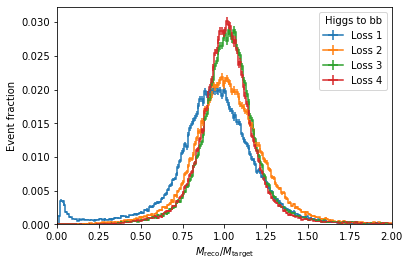

In [19]:
mass = hist.Hist('Event fraction',
                 hist.Cat('sample', 'Higgs to bb'),
                 hist.Bin('mass', '$M_{\\rm reco}$/$M_{\\rm target}$', 200, 0, 2),
                )

mass.fill(sample='Loss 1', mass=events1.output[events1.label_H_bb==1]/events1.target_mass[events1.label_H_bb==1])
mass.fill(sample='Loss 2', mass=events2.output[events2.label_H_bb==1]/events2.target_mass[events2.label_H_bb==1])
mass.fill(sample='Loss 3', mass=events3.output[events.label_H_bb==1]/events3.target_mass[events.label_H_bb==1])
mass.fill(sample='Loss 4', mass=events4.output[events4.label_H_bb==1]/events4.target_mass[events4.label_H_bb==1])

# am not sure this is the correct way to do events fraction
scales = {'Loss 1': 1/len(events1.event_no[events1.label_H_bb==1]), 
          'Loss 2': 1/len(events2.event_no[events2.label_H_bb==1]), 
          'Loss 3': 1/len(events3.event_no[events3.label_H_bb==1]), 
          'Loss 4': 1/len(events4.event_no[events4.label_H_bb==1]), 
         }
mass.scale(scales, axis='sample')

ax = hist.plot1d(mass, overlay='sample')
# ax.legend(frameon=False)

In [7]:
# function for computing mass resolution
def getEffSigma(theHist, wmin=0.2, wmax=180, epsilon=0.01):

    point = wmin
    weight = 0.0
    points = []
    # number of all jets
    thesum = theHist.sum("sample", "mass").values()[()]

    # number of jets in each bin
    values = theHist.sum("sample").values()[()]

    # bin centers
    centers = theHist.to_hist().axes['mass'].centers

    # fill list of bin centers and the integral up to those points
    for i, value in enumerate(values):
        weight += value
        points.append([centers[i], weight / thesum])

    low = wmin
    high = wmax

    # loop over all possible bin combninations and find the one
    # with smallest width and ~68% of all jets
    width = wmax - wmin
    for i in range(len(points)):
        for j in range(i, len(points)):
            wy = points[j][1] - points[i][1]
#             print(wy)
            if abs(wy - 0.683) < epsilon:
#                 print("here")
                wx = points[j][0] - points[i][0]
#                 print(wx)
                if wx < width:
                    low = points[i][0]
                    high = points[j][0]
                    # print(points[j][0], points[i][0], wy, wx)
                    width = wx
    print(low, high)
    return 0.5 * (high - low)

targetmasses = np.array([60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180])
loss1 = np.zeros(len(targetmasses))
loss2 = np.zeros(len(targetmasses))
loss3 = np.zeros(len(targetmasses))
loss4 = np.zeros(len(targetmasses))

for i in range(len(targetmasses)):
    targetmass = targetmasses[i]
    
    # loss 1
    hist1 = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hist1.fill(sample='H->bb (regression)', 
                  mass=events1.output[(events1.fj_gen_mass==targetmass) & (events1.label_H_bb==1)]/events1.target_mass[(events1.fj_gen_mass==targetmass) & (events1.label_H_bb==1)])

    loss1[i] = getEffSigma(hist1)
    
    # loss 2
    hist2 = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hist2.fill(sample='H->bb (regression)', 
                  mass=events2.output[(events2.fj_gen_mass==targetmass) & (events2.label_H_bb==1)]/events2.target_mass[(events2.fj_gen_mass==targetmass) & (events2.label_H_bb==1)])

    loss2[i] = getEffSigma(hist2)
    
    # loss 3
    hist3 = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hist3.fill(sample='H->bb (regression)', 
                  mass=events3.output[(events3.fj_gen_mass==targetmass) & (events3.label_H_bb==1)]/events3.target_mass[(events3.fj_gen_mass==targetmass) & (events3.label_H_bb==1)])

    loss3[i] = getEffSigma(hist3)
    
    # loss 4
    hist4 = hist.Hist("Events",
                         hist.Cat("sample", "sample name"),
                         hist.Bin("mass", "Mass", 200, 0, 2)
                        )

    hist4.fill(sample='H->bb (regression)', 
                  mass=events4.output[(events4.fj_gen_mass==targetmass) & (events4.label_H_bb==1)]/events4.target_mass[(events4.fj_gen_mass==targetmass) & (events4.label_H_bb==1)])

    loss4[i] = getEffSigma(hist4)

/opt/conda/lib/python3.8/site-packages/hist/basehist.py:110: UserWarning: sample is a protected keyword and cannot be used as axis name
  warnings.warn(disallowed_warning)


0.825 1.385
1.005 1.395
1.015 1.215
0.995 1.215
0.815 1.295
0.945 1.305
0.885 1.145
0.915 1.165
0.825 1.255
0.895 1.255
0.855 1.165
0.845 1.135
0.865 1.255
0.875 1.225
0.845 1.175
0.845 1.155
0.835 1.175
0.845 1.185
0.865 1.175
0.875 1.165
0.785 1.105
0.835 1.155
0.865 1.155
0.855 1.135
0.795 1.095
0.835 1.135
0.885 1.155
0.875 1.135
0.765 1.045
0.815 1.095
0.895 1.145
0.855 1.105
0.755 1.015
0.795 1.065
0.875 1.115
0.865 1.095
0.765 1.005
0.785 1.035
0.845 1.075
0.855 1.075
0.725 0.945
0.785 1.015
0.845 1.055
0.835 1.045
0.685 0.905
0.765 0.985
0.815 1.025
0.825 1.025
0.665 0.875
0.735 0.955
0.805 1.005
0.795 1.005


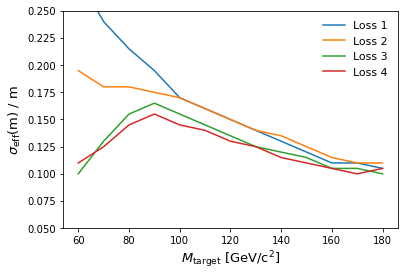

In [9]:
plt.plot(targetmasses, loss1, label='Loss 1', c='C0')
plt.plot(targetmasses, loss2, label='Loss 2', c='C1')
plt.plot(targetmasses, loss3, label='Loss 3', c='C2')
plt.plot(targetmasses, loss4, label='Loss 4', c='C3')

plt.legend(fontsize=11, frameon=False)
plt.xlabel('$M_{\\rm target}$ [GeV/${\\rm c}^2$]', fontsize=13)
plt.ylabel('$\sigma_{\\rm eff}$(m) / m', fontsize=13)
plt.ylim([0.05, 0.25])
plt.show()